In [1]:
# load and evaluate a saved model
from numpy import loadtxt
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

# load model
model = load_model('model1770.h5')
# summarize model.
model.summary()
# load dataset
df = pd.read_csv("pc_1770.csv")
df = df['Product_Demand']
# split into input (X) and output (Y) variables

# evaluate the model
#score = model.evaluate(X, Y, verbose=0)
#print("%s: %.2f%%" % (model.metrics_names[1], score[1]*100))

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d_2 (ConvLSTM2D)  (None, 1, 98, 64)         50176     
_________________________________________________________________
flatten_2 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 6273      
Total params: 56,449
Trainable params: 56,449
Non-trainable params: 0
_________________________________________________________________


In [2]:
# preparing independent and dependent features
def prepare_data(timeseries_data, n_features):
	X, y =[],[]
	for i in range(len(timeseries_data)):
		# find the end of this pattern
		end_ix = i + n_features
		# check if we are beyond the sequence
		if end_ix > len(timeseries_data)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = timeseries_data[i:end_ix], timeseries_data[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [3]:
# define input sequence
timeseries_data = df.to_numpy()
# choose a number of time steps
n_steps = 100
# split into samples
X, y = prepare_data(timeseries_data, n_steps)

In [4]:
# choose a number of time steps
n_steps = 100
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 1
n_steps = 100
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))

In [5]:
model.evaluate(X, y, verbose=0)

0.8531253580693845

In [6]:
# demonstrate prediction for next n days
#temp_input=list(x_input)
def logic(j):
    
    global timeseries_data
    timeseries_data = timeseries_data.astype(float)
    x_input=timeseries_data[-100:].reshape(1,-1)
    temp_input=list(x_input)
    temp_input=temp_input[0].tolist()
    
    lst_output=[]
    i=0
    while(i<j):

        if(len(temp_input)>100):
            x_input=np.array(temp_input[1:])
            print("{} day input {}".format(i,x_input))
            #print(x_input)
            x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
            #print(x_input)
            yhat = model.predict(x_input, verbose=0)
            print("{} day output {}".format(i,yhat))
            temp_input.append(yhat[0][0])
            temp_input=temp_input[1:]
            #print(temp_input)
            lst_output.append(yhat[0][0])
            i=i+1
        else:
            x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
            yhat = model.predict(x_input, verbose=0)
            print(yhat[0])
            temp_input.append(yhat[0][0])
            lst_output.append(yhat[0][0])
            i=i+1


    #print(lst_output) 
    return lst_output

In [7]:
j=6  #number of days to be predicted for demand
predictions = logic(j)
#print(lst_output)

[2.0725832]
1 day input [ 2.         2.         1.         2.         1.         2.
  4.         2.         1.         2.         1.         2.
  1.         1.        30.         2.         5.         1.
  2.         2.         2.         2.         2.         1.
  2.         1.         5.         2.         3.         4.
 10.         1.         1.         1.        10.         3.
  1.        12.         2.        10.         1.         1.
  1.         1.         2.         1.         7.         2.
  2.        10.         4.         1.         1.         1.
 10.         1.         1.         1.         3.         1.
  1.         2.         1.         1.         1.         2.
 10.         2.         1.         2.         1.         1.
  2.         1.         1.         1.         1.         1.
  2.         1.         2.        10.         5.         2.
  1.         4.         1.         3.         1.         2.
 10.         1.         1.         5.         3.         1.
 11.         2. 

In [8]:
predictions

[2.0725832, 9.918931, 16.519447, 3.8017795, 0.0, 5.376458]

In [9]:
list2 = [1 if i == 0 else i for i in predictions]
print(list2)

[2.0725832, 9.918931, 16.519447, 3.8017795, 1, 5.376458]


In [10]:
import math

class EOQ_Model:
    def __init__(self, demand=0, order=0, holding=0, cost=0, lead=0, planned_shortage=False, shortage_cost=0):
        self.demand = demand
        self.order = order
        self.holding = holding
        self.cost = cost
        self.lead = lead
        self.planned_shortage = planned_shortage
        self.shortage_cost = shortage_cost
        
        
    def optimal_order_quantity(self, d=None, o=None, h=None, s=None):
        '''
        Calculate the order qunatity
        
        d = demand
        o = ordering cost
        h = holding cost
        returns = reorder optimal quantity
        
        '''
        if d is None:
            d = self.demand       
        if o is None:
            o = self.order
        if h is None: 
            h = self.holding
        if s is None:
            s = self.shortage_cost
            
        if self.planned_shortage:
            return math.sqrt((2*d*o)/h) * math.sqrt(self.shortage_cost/(self.shortage_cost + self.holding))
        else:
            return math.sqrt((2*d*o)/h)
        
        
    def reorder_point(self, d=None, l=None):
        '''
        Calculates the reorder point with no planned shortages.

        d: total demand
        l: lead time
        returns: reorder point
        '''
        if d is None:
            d = self.demand
        if L is None:
            L = self.lead
        return d * l
    
        
    def optimal_cycle_time(self, d=None, o=None, h=None, s=None):
        '''
        Calculates the optimal cycle time.
        
        d: total demand
        o: ordering cost
        h: holding cost
        returns: reorder point
        '''
        
        if d is None:
            d = self.demand 
        if o is None:
            o = self.order
        if h is None: 
            h = self.holding
        if s is None:
            s = self.shortage_cost
            
        if self.planned_shortage:
            return math.sqrt((2*o)/(h*d)) * math.sqrt((self.shortage_cost + self.holding)/self.shortage_cost)
        else:
            return math.sqrt((2*o)/(h*d))
        
    
    def complete_calculations(self):
        '''Calculates and prints the main 2 metrics: order quantity, optimal cycle time
        
        :returns: tuple of metrics
        :rtype: tuple of length 2
        '''
        
        q = self.optimal_order_quantity()
        t = self.optimal_cycle_time()
        q = round(q)
        t = round(t, 3)
        print("Optimal Order Quantity (q*): {} units".format(q))
        print("Optimal Cycle Time (t*): {}".format(t)) 

In [11]:
l=2             #l = day on which EOQ is applied
d=list2[l]
o=100
c=20
h=2
s=0.8

eoqmodel = EOQ_Model(demand=d, order=o, cost=c, holding=h, planned_shortage=False, shortage_cost=s)
eoqmodel.complete_calculations()

Optimal Order Quantity (q*): 41 units
Optimal Cycle Time (t*): 2.46


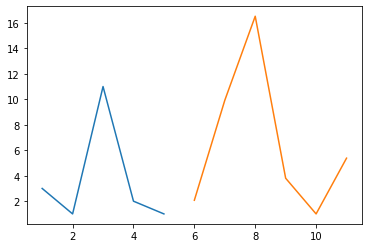

In [13]:
import matplotlib.pyplot as plt
a = j-1
day_new=np.arange(1,j)
day_pred=np.arange(j,j+j)
plt.plot(day_new,timeseries_data[-a:])
plt.plot(day_pred,list2)